# Import block

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

from prophet import Prophet

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

# Function block

In [180]:
def print_metrics(df: pd.DataFrame, df_pred: pd.DataFrame):
    '''
    Printing metrics (MSE, RMSE, MAE, MAPE)
    skleast import needed:
    from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
    '''
    mse = mean_squared_error(df, df_pred)
    print(f'MSE is: {mse}')
    print(f'RMSE is: {np.sqrt(mse)}')
    print(f'MAE is: {mean_absolute_error(df, df_pred)}')
    print(f'MAPE is: {mean_absolute_percentage_error(df, df_pred)}')
    
    
def plot_forecast(df: pd.DataFrame, forecast: pd.DataFrame):
    '''
    Plot Original signal and Prophet prediction:
    yhat - prediction
    trend - prediction trend part    
    '''
    fig, ax = plt.subplots(figsize=(15, 5))
    ax.set_title=('Prophet forecast')
    fig = sns.lineplot(x=pd.to_datetime(df['ds']), y=df['y'], label='Original', lw=1, ax=ax)
    fig = sns.lineplot(x=pd.to_datetime(forecast['ds']), y=forecast['yhat'], label='Forecast', lw=1, ax=ax)
    fig = sns.lineplot(x=pd.to_datetime(forecast['ds']), y=forecast['trend'], label='Trend', lw=1, ax=ax)
    plt.show()

# Loading data

In [5]:
df_transactions = pd.read_csv('data\\part_2_prophet\\transactions.csv')
df_holidays_events = pd.read_csv('data\\part_2_prophet\\holidays_events.csv')

In [37]:
df_transactions.sample(5)

,date,store_nbr,transactions
46047,2015-09-01,32,672
78618,2017-05-17,45,3553
57805,2016-04-15,13,791
60409,2016-06-03,20,1322
25926,2014-07-13,46,3947


# Задание 1. Приведите данные train.csv к виду временного ряда, скрупировать по даже с агрегирующей функцией SUM для столбца unit_sales. Должен получиться временной ряд с двумя столбцами: дата и sum_unit_sales. Отобразите на графике. Видно ли влияние сезонности и других факторов на количество покупок?

In [17]:
df = df_transactions.groupby('date')['transactions'].sum()
df.index = pd.to_datetime(df.index)

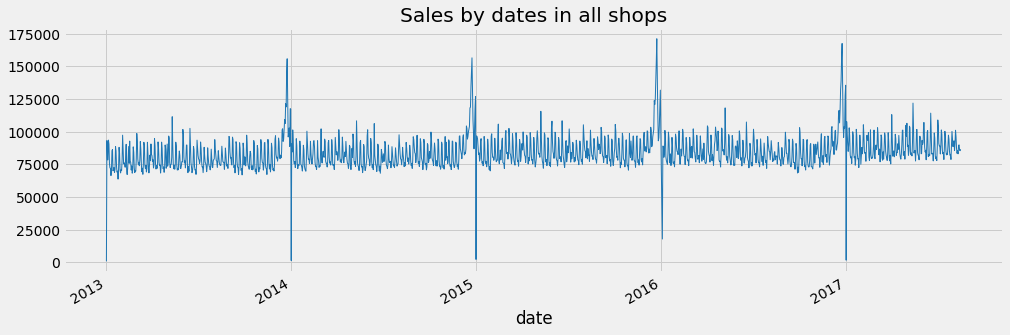

In [7]:
df.plot(
    figsize=(15, 5),
    color=color_pal[0],
    title='Sales by dates in all shops',
    lw=1
)
plt.show()

# Задание 2. Выполните предсказание пророком на год вперед. Отобразите на графике. Посчитайте RMSE.

In [18]:
df = df.reset_index().rename(columns={'date': 'ds', 'transactions': 'y'})

In [19]:
model = Prophet()
model.fit(df)
future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)

11:39:20 - cmdstanpy - INFO - Chain [1] start processing
11:39:20 - cmdstanpy - INFO - Chain [1] done processing


In [125]:
forecast.sample(5)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1016,2015-10-16,87035.951815,70959.514345,91124.509626,87035.951815,87035.951815,-5922.619668,-5922.619668,-5922.619668,-1655.857936,-1655.857936,-1655.857936,-4266.761732,-4266.761732,-4266.761732,0.0,0.0,0.0,81113.332147
1985,2018-06-15,99735.983236,71882.905688,118906.353150,78078.623749,119790.839043,-2600.709488,-2600.709488,-2600.709488,-1655.857936,-1655.857936,-1655.857936,-944.851552,-944.851552,-944.851552,0.0,0.0,0.0,97135.273748
2036,2018-08-05,100972.850277,76877.371522,133848.864520,72452.602624,127641.430212,4650.435663,4650.435663,4650.435663,7552.008142,7552.008142,7552.008142,-2901.572479,-2901.572479,-2901.572479,0.0,0.0,0.0,105623.285941
1187,2016-04-07,86869.279986,69094.388895,89606.254813,86869.279986,86869.279986,-7781.072835,-7781.072835,-7781.072835,-7236.162628,-7236.162628,-7236.162628,-544.910206,-544.910206,-544.910206,0.0,0.0,0.0,79088.207151
273,2013-10-01,81584.746050,64794.453787,84138.174942,81584.746050,81584.746050,-6617.336571,-6617.336571,-6617.336571,-4833.868851,-4833.868851,-4833.868851,-1783.467720,-1783.467720,-1783.467720,0.0,0.0,0.0,74967.409479


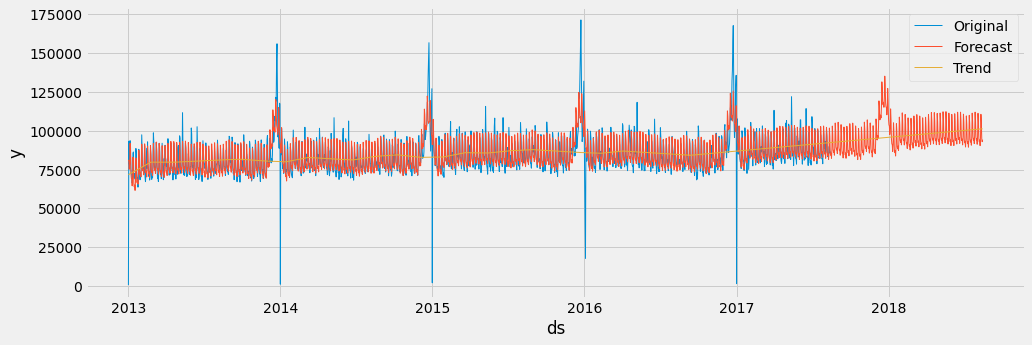

In [127]:
plot_forecast(df, forecast)

In [55]:
print_metrics(df['y'], forecast['yhat'][:1682])

MSE is: 62458899.008144386
RMSE is: 7903.094267952546
MAE is: 4075.678755350518
MAPE is: 0.2136723950991247


# Задание 3. Поэкспериментируйте с коэффициентом changepoint_prior_scale (переберите 2-5 значений >< 0,5) и посмотрите, как изменится тренд. В какую сторону необходимо двигать коэффициент? Тренд переобучен или недообучен?

In [128]:
koef_to_rmse = np.empty([0, 2])
for i in range (15, 50, 5):
    print(f'changepoint_prior_scale= {i / 10}')
    m = Prophet(changepoint_prior_scale=i / 10)
    m.fit(df)
    future = m.make_future_dataframe(periods=365)
    forecast = m.predict(future)
    koef_to_rmse = np.vstack([koef_to_rmse, [i / 10, np.sqrt(mean_squared_error(df['y'], forecast['yhat'][:1682]))]])

changepoint_prior_scale= 1.5


14:28:12 - cmdstanpy - INFO - Chain [1] start processing
14:28:13 - cmdstanpy - INFO - Chain [1] done processing


changepoint_prior_scale= 2.0


14:28:13 - cmdstanpy - INFO - Chain [1] start processing
14:28:14 - cmdstanpy - INFO - Chain [1] done processing


changepoint_prior_scale= 2.5


14:28:14 - cmdstanpy - INFO - Chain [1] start processing
14:28:15 - cmdstanpy - INFO - Chain [1] done processing


changepoint_prior_scale= 3.0


14:28:16 - cmdstanpy - INFO - Chain [1] start processing
14:28:16 - cmdstanpy - INFO - Chain [1] done processing


changepoint_prior_scale= 3.5


14:28:17 - cmdstanpy - INFO - Chain [1] start processing
14:28:17 - cmdstanpy - INFO - Chain [1] done processing


changepoint_prior_scale= 4.0


14:28:18 - cmdstanpy - INFO - Chain [1] start processing
14:28:18 - cmdstanpy - INFO - Chain [1] done processing


changepoint_prior_scale= 4.5


14:28:19 - cmdstanpy - INFO - Chain [1] start processing
14:28:20 - cmdstanpy - INFO - Chain [1] done processing


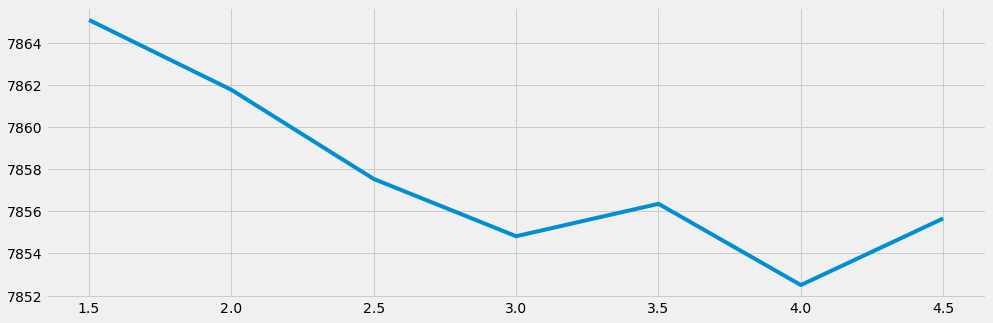

In [79]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(x=koef_to_rmse[:, 0], y=koef_to_rmse[:, 1])
plt.show()

In [117]:
best_changepoint = koef_to_rmse[np.where(koef_to_rmse[:,1] == np.min(koef_to_rmse[:,1]))][0][0]

In [120]:
m = Prophet(changepoint_prior_scale=best_changepoint)
m.fit(df)
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)

13:10:19 - cmdstanpy - INFO - Chain [1] start processing
13:10:20 - cmdstanpy - INFO - Chain [1] done processing


In [121]:
print_metrics(df['y'], forecast['yhat'][:1682])

MSE is: 61661717.722053304
RMSE is: 7852.497546771556
MAE is: 4032.8470708863138
MAPE is: 0.21012234459935678


# Задание 4. Отобразите результаты с подобранным коэффициентом на графике. Как изменилась ошибка?

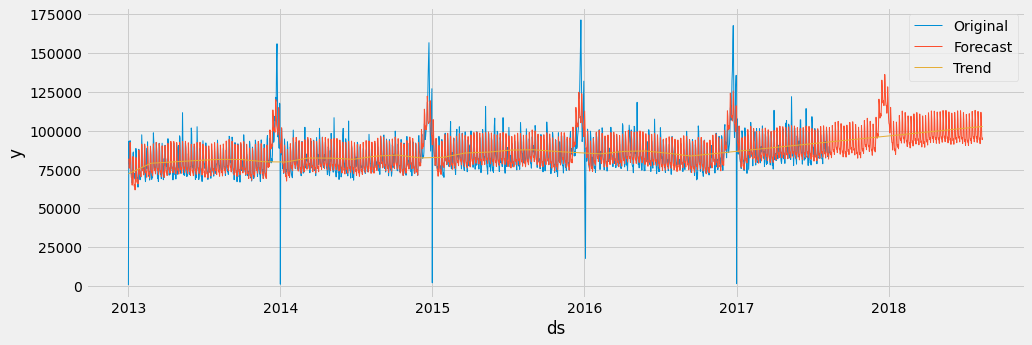

In [134]:
plot_forecast(df, forecast)

**Ошибка была 7903, стала 7852. Изменение совсем незначительное.**

**При changepoint_prior_scale= 3.0 RMSE снизилась до 7854.815929289345. Trend стал более следовать за сигналом. При значении 4.0 ошибка немного уменьшилась, но тренд по моему мнению стал переобучаться. Оставлю changepoint_prior_scale= 3.0**

# Задание 5. Добавить в модель месячную сезонность. Как изменилась ошибка? Улучлилась ли модель? Отобразить на графике. Посчитать ошибку.

In [136]:
m = Prophet(changepoint_prior_scale=best_changepoint)
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
m.fit(df)
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)

14:52:58 - cmdstanpy - INFO - Chain [1] start processing
14:52:59 - cmdstanpy - INFO - Chain [1] done processing


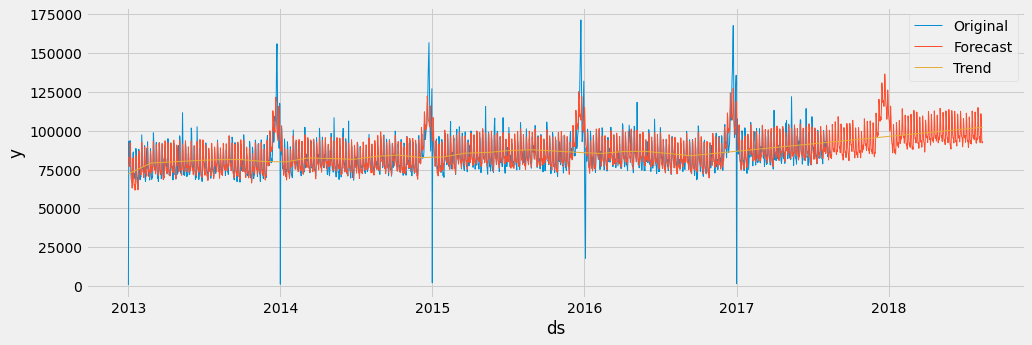

In [138]:
plot_forecast(df, forecast)

In [149]:
print(f'changepoint_prior_scale = {best_changepoint} and monthly = ON')
print_metrics(df['y'], forecast['yhat'][:1682])

changepoint_prior_scale = 4.0 and monthly = ON
MSE is: 24273052.364551384
RMSE is: 4926.768957902469
MAE is: 2601.355418616028
MAPE is: 0.07133221135735797


**Добавление сезонности улучшило модель до ошибки в 7680**

# Задание 6. Улучшите модель добавлением данных о праздниках. Отобразите результат, сделайте вывод.

In [171]:
holidays = df_holidays_events.query('transferred == False')[['description', 'date']].rename(columns={'description': 'holiday', 'date': 'ds'})
holidays.sample(5)

,holiday,ds
32,Cantonizacion de Salinas,2012-12-22
151,Cantonizacion de Salinas,2014-12-22
197,Independencia de Ambato,2015-11-12
315,Provincializacion de Imbabura,2017-06-25
186,Fundacion de Riobamba,2015-08-15


In [172]:
m = Prophet(changepoint_prior_scale=best_changepoint, holidays=holidays)
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
m.fit(df)
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)

15:21:34 - cmdstanpy - INFO - Chain [1] start processing
15:21:35 - cmdstanpy - INFO - Chain [1] done processing


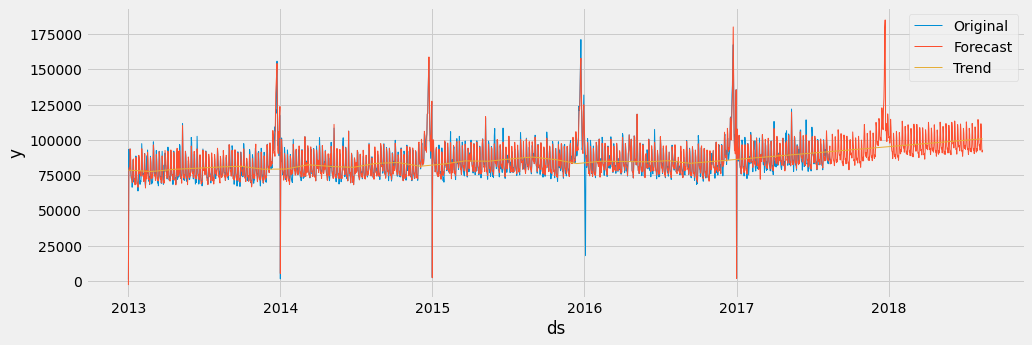

In [169]:
plot_forecast(df, forecast)

In [173]:
print(f'changepoint_prior_scale = {best_changepoint}, monthly=ON, holidays=ON')
print_metrics(df['y'], forecast['yhat'][:1682])

changepoint_prior_scale = 4.0, monthly=ON, holidays=ON
MSE is: 24273052.364551384
RMSE is: 4926.768957902469
MAE is: 2601.355418616028
MAPE is: 0.07133221135735797


In [174]:
holidays['lower_window'] = -1
holidays['upper_window'] = 1

In [175]:
m = Prophet(changepoint_prior_scale=best_changepoint, holidays=holidays)
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
m.fit(df)
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)

15:22:03 - cmdstanpy - INFO - Chain [1] start processing
15:22:10 - cmdstanpy - INFO - Chain [1] done processing


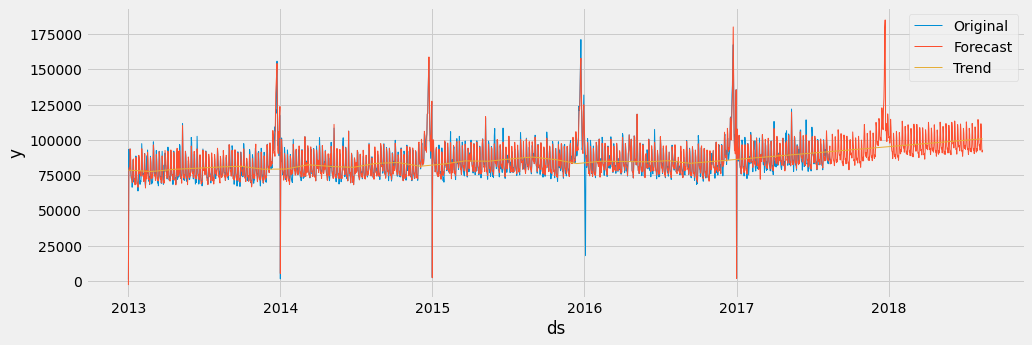

In [176]:
plot_forecast(df, forecast)

In [177]:
print(f'changepoint_prior_scale = {best_changepoint}, monthly=ON, holidays=ON')
print_metrics(df['y'], forecast['yhat'][:1682])

changepoint_prior_scale = 4.0, monthly=ON, holidays=ON
MSE is: 13445627.982216185
RMSE is: 3666.8280546292576
MAE is: 2179.1973355458854
MAPE is: 0.03201551588918501


**Ошибка уменьшилась до 4926, что при минимальных настройках уже отлично. Информация о праздниках сработала отлично. Модель увидела сезонные пики (праздники). Но после 3 пиков вниз перестала дальше предсказывать их. Возможно сместились праздничные дни. Также при включении дней до и после праздников ушибка кардинально уменьшилась до 3666**